# Final Project: Tasten Klassifizierung anhand des Geräuchs mittels Keras und Tensorflow 
### Universität: Hochschule der Medien Stuttgart
**Fakultät für Berufsbegleitende Studiengänge**

**Studiengang:** Data Science

**Abgabedatum:** 01.30.2024

**Professor:** Johannes Maucher

**Student:** Raghid Allaham

## idea and approaches

## research question

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv1D,MaxPool1D, AveragePooling1D
from tensorflow.keras.optimizers import SGD, Adam
import pandas as pd
import seaborn as sns
from imutils import paths
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import confusion_matrix, classification_report


import librosa

In [68]:
# Laden einer .wav-Datei
audio_path = './Data/lernwelt/1_2024-01-21_12-11-24.wav'
audio, sr = librosa.load(audio_path, sr=None)


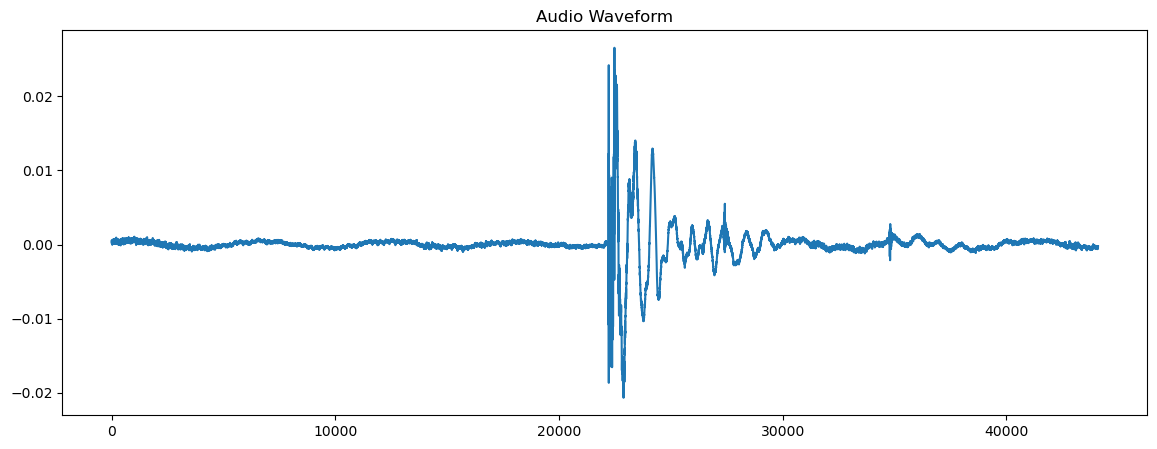

In [69]:
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Waveform')
plt.show()

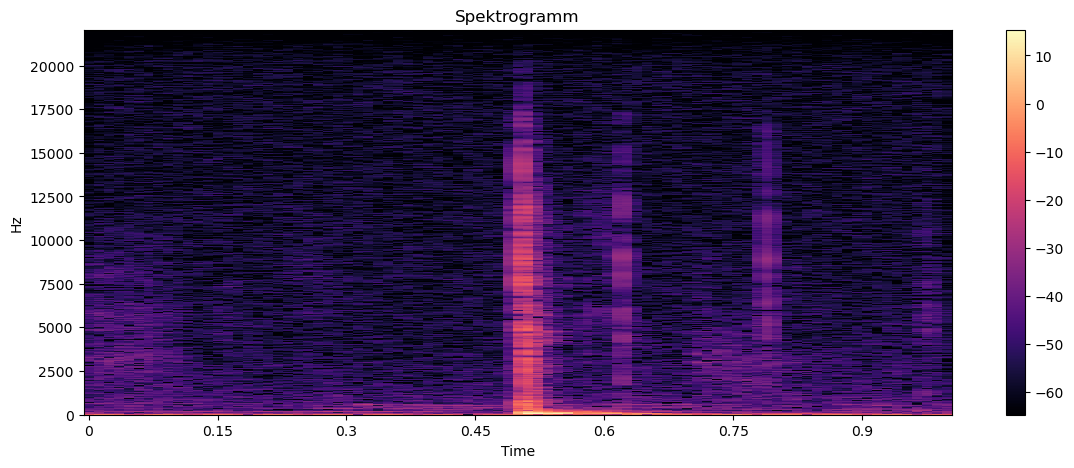

In [70]:
import librosa.display
import numpy as np

X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spektrogramm')
plt.show()


In [74]:
import os


base_path = './classes_lw'  # Basispfad zu Ihren Audiodateien
classes = os.listdir(base_path)  # Liste der Klassennamen

data = []  # Liste zum Speichern der Audiodaten
labels = []  # Liste zum Speichern der zugehörigen Labels

for class_label in classes:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                audio, sr = librosa.load(file_path, sr=None)  # Laden der Audiodatei
                audio = audio / np.max(np.abs(audio))  # Normalisierung
                data.append(audio)
                labels.append(class_label)


In [81]:
print(type(data))

<class 'list'>


In [75]:
print(f"Data matrix shape: {len(data)} x {len(data[0])}")

Data matrix shape: 525 x 44100


In [76]:
classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'enter', 'esc', 'shift', 'space']

In [77]:
# Check if all data has the same legnth
leng_data= len(data[0])
for i in data:
    if len(i)!=leng_data:
        print(i)
    

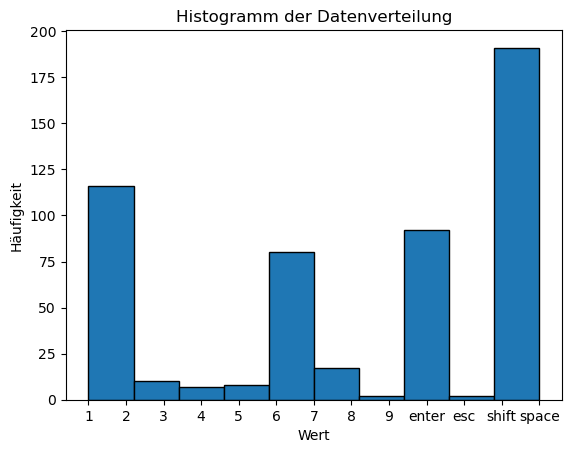

In [78]:
plt.hist(labels, edgecolor='black')
plt.title('Histogramm der Datenverteilung')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

we also need to filter for the relevant classes: ['shift','space','enter','1','6']

In [102]:
relevant_classes = ['1','6','shift','space','enter']

data = []  # Liste zum Speichern der Audiodaten
labels = []  # Liste zum Speichern der zugehörigen Labels

for class_label in relevant_classes:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                audio, sr = librosa.load(file_path, sr=None)  # Laden der Audiodatei
                audio = audio / np.max(np.abs(audio))  # Normalisierung
                data.append(audio)
                labels.append(class_label)


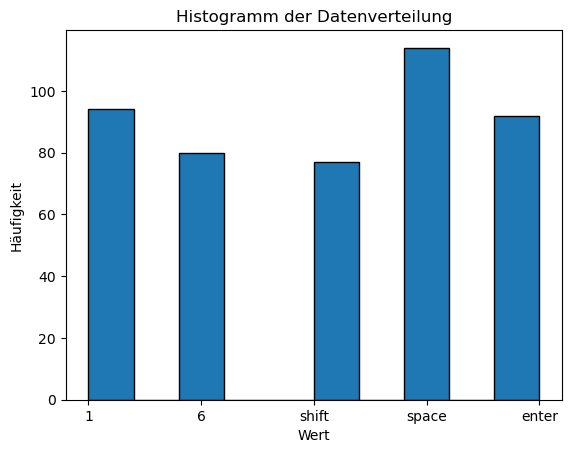

In [103]:
plt.hist(labels, edgecolor='black')
plt.title('Histogramm der Datenverteilung')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

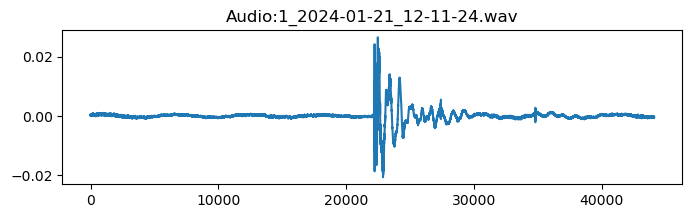

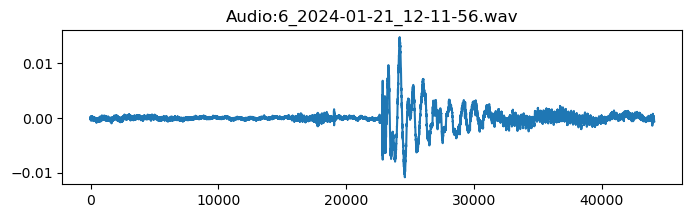

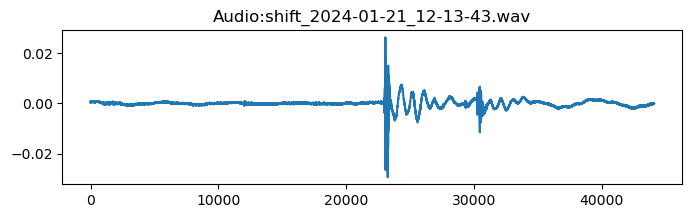

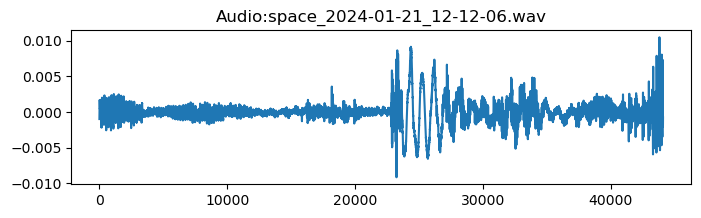

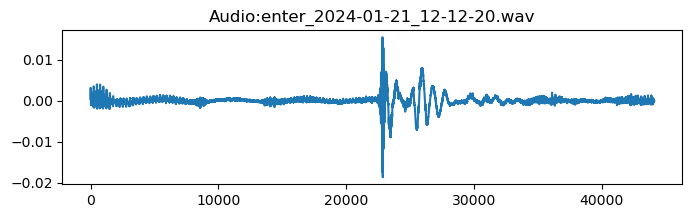

In [104]:
for cli, i in enumerate(relevant_classes):
    subfolder = "./classes_lw/" + i
    wav = os.listdir(subfolder)[0]
    audio, sr = librosa.load(subfolder + "/" + wav, sr=None)
    plt.figure(figsize=(8, 2))
    plt.plot(audio)
    plt.title('Audio:' + wav)
plt.show()
    


From the picture above we can see that we are mostily intrested in the erea between 20000 and 4400 this why we will cut the first 10000 points away.

In [105]:
trimmed_data = [array[10000:] for array in data]
print(len(trimmed_data),len(trimmed_data[0]) )

457 34100


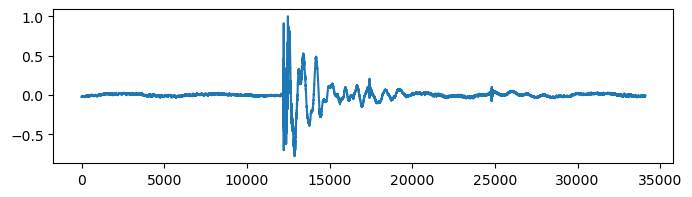

In [106]:
plt.figure(figsize=(8, 2))
plt.plot(trimmed_data[0])
plt.show()

In [127]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Ergebnis anzeigen
print(encoded_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [150]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.array(trimmed_data) 
y = to_categorical(encoded_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [151]:
from tensorflow.keras.layers import Conv1D, MaxPool1D

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(len(trimmed_data[0]), 1), activation='relu'))
model.add(AveragePooling1D(pool_size=4))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu',padding='same'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 34098, 64)         256       
                                                                 
 average_pooling1d_11 (Aver  (None, 8524, 64)          0         
 agePooling1D)                                                   
                                                                 
 dropout_55 (Dropout)        (None, 8524, 64)          0         
                                                                 
 conv1d_57 (Conv1D)          (None, 8524, 32)          10272     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 4262, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_58 (Conv1D)          (None, 4262, 32)        

In [152]:
epochs = 14
lrate = 0.01
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.8, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

In [153]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode='min', restore_best_weights=True)

In [154]:
print(len(X_val))
print(len(y_val))
y_train

138
138


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [155]:
len(X) != len(y)

False

In [156]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=16, callbacks=[early_stopping])
model.save("./Modell/audio_classifyer")

Epoch 1/14


107/107 [==============================] - 58s 532ms/step - loss: 1.6068 - accuracy: 0.3009 - val_loss: 1.6512 - val_accuracy: 0.1739
Epoch 2/14
107/107 [==============================] - 55s 510ms/step - loss: 1.5919 - accuracy: 0.2947 - val_loss: 1.6177 - val_accuracy: 0.1739
Epoch 3/14
107/107 [==============================] - 54s 502ms/step - loss: 1.4733 - accuracy: 0.3386 - val_loss: 1.4128 - val_accuracy: 0.3623
Epoch 4/14
107/107 [==============================] - 51s 480ms/step - loss: 1.3357 - accuracy: 0.4169 - val_loss: 1.4113 - val_accuracy: 0.2826
Epoch 5/14
107/107 [==============================] - 51s 474ms/step - loss: 1.2705 - accuracy: 0.4389 - val_loss: 1.3769 - val_accuracy: 0.3261
Epoch 6/14
107/107 [==============================] - 51s 478ms/step - loss: 1.1737 - accuracy: 0.5078 - val_loss: 1.3238 - val_accuracy: 0.4130
Epoch 7/14
107/107 [==============================] - 51s 475ms/step - loss: 1.1269 - accuracy: 0.5141 - val_loss: 1.3600 - val_accuracy: 0.3

INFO:tensorflow:Assets written to: ./Modell/audio_classifyer\assets


In [184]:
loss,acc = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 57.99%


In [185]:
loss,acc = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 41.30%


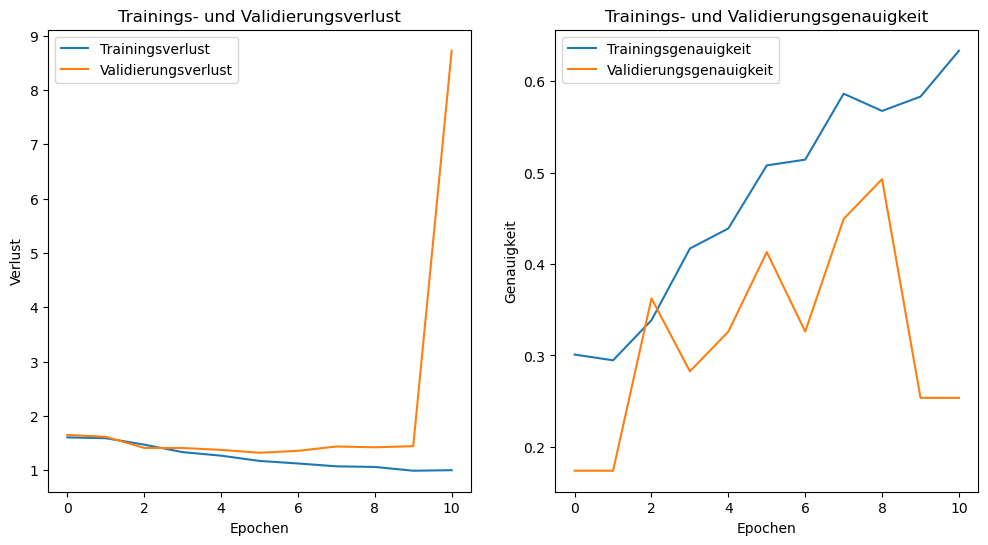

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()

# Plot für Trainings- und Validierungsgenauigkeit
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

plt.show()

In [192]:
predictions = model.predict(X_val)

5/5 [==============================] - 1s 201ms/step


In [193]:
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_val, axis=1)

In [194]:
predicted_classes

array([4, 0, 3, 4, 0, 3, 4, 1, 3, 4, 4, 1, 2, 3, 3, 0, 3, 3, 3, 3, 0, 1,
       3, 1, 3, 3, 0, 3, 0, 4, 3, 3, 3, 0, 2, 4, 4, 0, 1, 2, 3, 4, 3, 0,
       1, 3, 0, 3, 3, 4, 4, 1, 3, 3, 3, 2, 1, 3, 1, 3, 2, 0, 0, 4, 3, 4,
       4, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 1, 4, 3, 1, 1,
       0, 0, 1, 4, 0, 4, 3, 3, 4, 1, 3, 0, 3, 4, 1, 3, 3, 4, 3, 3, 1, 3,
       1, 0, 0, 1, 4, 4, 4, 3, 2, 2, 1, 3, 2, 0, 3, 3, 3, 4, 0, 3, 3, 0,
       3, 3, 1, 0, 4, 1], dtype=int64)

In [195]:
actual_classes

array([4, 0, 4, 3, 1, 3, 1, 1, 2, 0, 0, 1, 1, 4, 2, 0, 2, 4, 2, 0, 0, 1,
       3, 1, 3, 2, 0, 2, 0, 4, 2, 3, 2, 1, 2, 0, 4, 4, 1, 0, 4, 0, 3, 0,
       1, 0, 0, 3, 2, 4, 4, 0, 3, 4, 2, 2, 0, 2, 0, 2, 2, 0, 0, 4, 2, 0,
       3, 2, 4, 3, 4, 2, 0, 2, 3, 4, 0, 3, 2, 1, 4, 4, 4, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 0, 0, 2, 4, 0, 0, 4, 1, 2, 4, 1, 3, 2, 2, 2, 3, 1, 2,
       0, 0, 3, 1, 2, 4, 0, 2, 2, 2, 0, 0, 2, 0, 2, 4, 3, 0, 1, 4, 3, 0,
       3, 3, 0, 0, 2, 1], dtype=int64)

In [196]:
cm = confusion_matrix(actual_classes, predicted_classes)

In [197]:
cm

array([[16, 10,  1,  3, 11],
       [ 5, 12,  1,  0,  1],
       [ 0,  1,  6, 25,  3],
       [ 1,  0,  0, 15,  3],
       [ 1,  1,  0, 14,  8]], dtype=int64)

In [198]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(8, 6)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

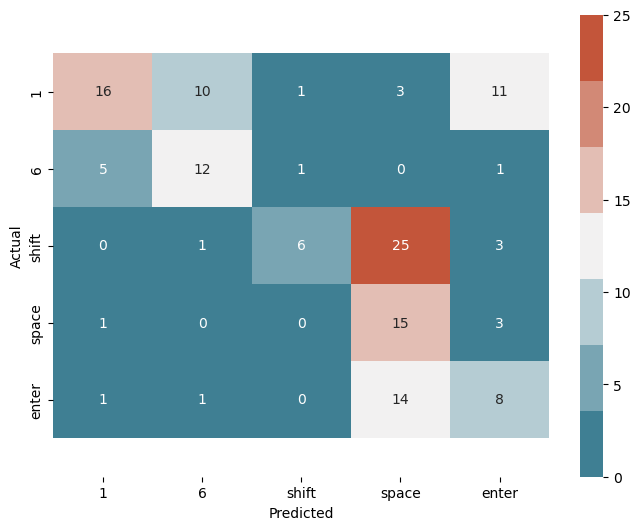

In [199]:
plot_cm(actual_classes, predicted_classes, relevant_classes)